## Installing MediaPipe

In [ ]:
!pip install Mediapipe
!pip install protobuf==3.20.*
!pip install opencv-python


## Import Libraries

In [141]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings

from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_linnerud
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.multioutput import RegressorChain
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')

## Helper Functions

In [2]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx == None and tdy == None:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),3)

    return img

## Preparing Data

In [3]:
# get all images name from dataset
def get_images_name(dir='AFLW2000/'):
  images = set()
  for filename in os.listdir(dir):
    if filename.endswith("jpg"):
      images.add(filename.split('.')[0])
  print('You have', len(images), 'images in your dataset')
  return images

In [134]:
# Creating DataFrame from Face Landmarks
def create_df(images, dir='AFLW2000/', draw_on=False, with_mat=False, with_image_name=False):
  
  faceModule = mediapipe.solutions.face_mesh

  images_data = []

  with faceModule.FaceMesh(static_image_mode=True) as faces:
    for image_name in images:
      # collecting image data (x, y of face landmark and pitch, yaw, roll)
      image_data = []
      cols = []
      # adding image name on data
      if with_image_name:
        image_data.append(image_name)
        cols += ['image_name']
      if draw_on:
        print('Image Name:', image_name)
      
      # loading the image
      image = cv2.imread(dir + image_name + '.jpg')

      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      cols += [x+str(i+1) for i in range(468) for x in ['X', 'Y']]

      if results.multi_face_landmarks != None:
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
          for landmark in face.landmark:
            x = landmark.x
            y = landmark.y
            # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
            shape = image.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            
            image_data.append(relative_x)
            image_data.append(relative_y)
            
            #cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 200, 0), thickness=2)

          #if draw_on:
            #plt.imshow(image)

      if with_mat:
        # loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
        mat_file = sio.loadmat('AFLW2000/' + image_name +'.mat')
        # extracting the labels 3 angels
        pose_para = mat_file["Pose_Para"][0][:3]
        pitch = pose_para[0]
        yaw = pose_para[1]
        roll = pose_para[2]
        image_data += [pitch, yaw, roll]
        cols += ['pitch', 'yaw', 'roll']

        if draw_on:
            print([pitch, yaw, roll])
            img = draw_axis(image,pitch,yaw,roll)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      images_data.append(image_data)
      
    
  df = pd.DataFrame(images_data, columns=cols)
  return df, image
      
            

In [5]:
images_name = get_images_name()

You have 2000 images in your dataset


In [6]:
df, img = create_df(images_name, draw_on=False, with_mat=True, with_image_name=True)
df.dropna(inplace=True)
df.head()

,image_name,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,...,Y465,X466,Y466,X467,Y467,X468,Y468,pitch,yaw,roll
0,image01602,210.0,300.0,189.0,273.0,207.0,278.0,190.0,243.0,186.0,...,211.0,220.0,214.0,266.0,191.0,271.0,185.0,-0.339877,0.943137,-0.492823
1,image03641,226.0,304.0,217.0,278.0,223.0,287.0,212.0,253.0,216.0,...,231.0,237.0,233.0,286.0,218.0,290.0,212.0,-0.133372,0.163064,-0.128209
2,image02953,228.0,315.0,223.0,289.0,226.0,294.0,213.0,253.0,221.0,...,217.0,238.0,221.0,297.0,197.0,301.0,194.0,-0.284248,-0.013198,-0.100999
3,image04196,214.0,308.0,205.0,281.0,212.0,289.0,203.0,248.0,204.0,...,223.0,236.0,225.0,296.0,215.0,302.0,212.0,-0.156882,0.404901,0.019756
4,image00939,246.0,297.0,248.0,273.0,242.0,282.0,229.0,249.0,247.0,...,227.0,230.0,229.0,256.0,214.0,258.0,210.0,0.018702,-0.456421,-0.306169


In [7]:
df.to_csv('all_data.csv',index=False)

In [8]:
#Crop Image to get Only the Face Function, returns the cropped Image
def crop_images(df, image_name, img_dir='AFLW2000/', crop_dir='CroppedImages/', save_cropped=True, show_image=False):
    image = cv2.imread(img_dir + image_name + '.jpg')
    
    df_test = df.loc[df['image_name'] == image_name]
    df_test_X = df_test.loc[:, df_test.columns.str.startswith('X')]
    df_test_Y = df_test.loc[:, df_test.columns.str.startswith('Y')]

    min_x = int(df_test_X.min(axis=1).values[0])
    max_x = int(df_test_X.max(axis=1).values[0])
    min_Y = int(df_test_Y.min(axis=1).values[0])
    max_Y = int(df_test_Y.max(axis=1).values[0])
        
    crop_top = image[min_Y:max_Y, min_x:max_x, :]
    
    if show_image:
        print(min_x, max_x, min_Y, max_Y)
        plt.figure(figsize=(10,10))
        plt.imshow(cv2.cvtColor(crop_top, cv2.COLOR_BGR2RGB))
        plt.show()
        #create_df([image_name], dir=img_dir, draw_on=True)

    if not os.path.exists(crop_dir):
        os.makedirs(crop_dir)
    if save_cropped and crop_top.size != 0:
        cv2.imwrite(crop_dir + image_name + '.jpg', crop_top)

    return crop_top

In [9]:
# Crop All Images and save them in CroppedImages Folder
for image in df['image_name']:
    crop_images(df, image)

In [10]:
images_name = get_images_name(dir='CroppedImages/')

You have 1852 images in your dataset


In [11]:
df_cropped, img = create_df(images_name, draw_on=False, with_mat=True, with_image_name=True, dir='CroppedImages/')
df_cropped.dropna(inplace=True)
df_cropped.head()

,image_name,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,...,Y465,X466,Y466,X467,Y467,X468,Y468,pitch,yaw,roll
0,image01602,40.0,162.0,17.0,138.0,35.0,143.0,15.0,110.0,13.0,...,79.0,41.0,82.0,83.0,60.0,87.0,55.0,-0.339877,0.943137,-0.492823
1,image03641,72.0,149.0,63.0,123.0,69.0,132.0,58.0,98.0,62.0,...,78.0,82.0,79.0,129.0,65.0,134.0,60.0,-0.133372,0.163064,-0.128209
2,image02953,113.0,192.0,109.0,166.0,111.0,172.0,98.0,130.0,107.0,...,93.0,123.0,97.0,180.0,73.0,184.0,71.0,-0.284248,-0.013198,-0.100999
3,image04196,70.0,172.0,61.0,145.0,69.0,153.0,60.0,112.0,60.0,...,88.0,92.0,90.0,151.0,78.0,157.0,75.0,-0.156882,0.404901,0.019756
4,image00939,145.0,133.0,149.0,109.0,142.0,117.0,129.0,86.0,147.0,...,64.0,129.0,65.0,155.0,48.0,157.0,44.0,0.018702,-0.456421,-0.306169


In [12]:
df_cropped.to_csv('cropped_data.csv',index=False)

In [111]:
X = df_cropped.drop(columns=['image_name', 'pitch', 'yaw', 'roll'])
y = df_cropped[['pitch', 'yaw', 'roll']]

## Preprocessing

#### PCA

In [100]:
def do_pca(X):
    pca = PCA(n_components=50)
    X = pca.fit_transform(X)
    return pca, X

In [112]:
pca, X = do_pca(X)
X.shape

(1759, 50)

#### Standardization

In [113]:
std = StandardScaler()
std.fit(X)
X = std.transform(X)

#### Splitting The Data

In [114]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train Data Shape: \t', x_train.shape, y_train.shape)
print('Test Data Shape: \t', x_test.shape, y_test.shape)

Train Data Shape: 	 (1407, 50) (1407, 3)
Test Data Shape: 	 (352, 50) (352, 3)


## Training

#### Linear SVR

In [18]:
params = {
    "estimator__epsilon": [0.01, 0.05, 0.1, 0.2, 0.3],
    "estimator__C": [0.001, 0.01, 0.05, 0.1],
    "estimator__loss": ["epsilon_insensitive", "squared_epsilon_insensitive"],
    "estimator__tol": [1e-4, 1e-5, 1e-6],
    "estimator__max_iter": [1000, 10000, 100000]
}

model = LinearSVR()
wrapper = MultiOutputRegressor(model)
wrapper.get_params().keys()

dict_keys(['estimator__C', 'estimator__dual', 'estimator__epsilon', 'estimator__fit_intercept', 'estimator__intercept_scaling', 'estimator__loss', 'estimator__max_iter', 'estimator__random_state', 'estimator__tol', 'estimator__verbose', 'estimator', 'n_jobs'])

In [19]:
clf = GridSearchCV(wrapper, params)
clf.fit(x_train,y_train)
clf.best_params_

{'estimator__C': 0.1,
 'estimator__epsilon': 0.05,
 'estimator__loss': 'epsilon_insensitive',
 'estimator__max_iter': 1000,
 'estimator__tol': 1e-06}

In [115]:
model = LinearSVR(C=0.1, dual=True, epsilon=0.05, loss='epsilon_insensitive', tol=1e-05, max_iter=10000)
wrapper = MultiOutputRegressor(model)
wrapper.fit(x_train, y_train)

MultiOutputRegressor(estimator=LinearSVR(C=0.1, epsilon=0.05, max_iter=10000,
                                         tol=1e-05))

In [142]:
y_pred = wrapper.predict(x_test)
print("R2 score: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))

R2 score:  0.8467297009001141
MSE:  0.013629925005930509
MAE:  0.07340385564182589


## Testing

#### From DataSet

In [130]:
img_names_slice = [df['image_name'].values[10]]

Image Name: image01996
[-0.11115791, 0.07430994, 0.009384186]


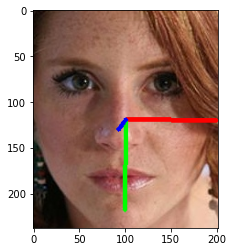

In [137]:
df_test, image = create_df(img_names_slice, draw_on=True, with_mat=True, dir='CroppedImages/', with_image_name=True)

Image Name: image01996
[-0.15162811  0.04641523  0.02638829]


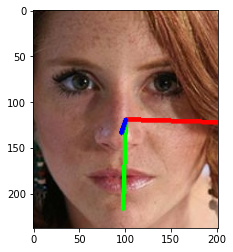

In [138]:
for img_name in df_test['image_name'].values:
  test_features = df_test.loc[df['image_name'] == img_name]
  test_features = df_test.drop(columns=['image_name', 'pitch', 'yaw', 'roll'])
  test_features = pca.transform(test_features)
  test_features = std.transform(test_features)
  y_pred = wrapper.predict(test_features)[0]
  pitch = y_pred[0]
  yaw = y_pred[1]
  roll = y_pred[2]

  img = cv2.imread('CroppedImages/' + img_name + '.jpg')
  img = draw_axis(img,pitch,yaw,roll)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  print('Image Name:', img_name)
  print(y_pred)

#### From Camera

In [89]:
def get_mesh_data(image, draw_mesh=False):
    faceModule = mediapipe.solutions.face_mesh
    
    images_data = []
    mesh_image = image.copy()

    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # collecting image data (x, y of face landmark and pitch, yaw, roll)
        image_data = []
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        if results.multi_face_landmarks != None:
            # looping over the faces in the image
            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    image_data.append(relative_x)
                    image_data.append(relative_y)
                    if draw_mesh:
                        cv2.circle(mesh_image, (relative_x, relative_y), radius=1, color=(0, 200, 0), thickness=2)
                    
    images_data.append(image_data)
    df = pd.DataFrame(images_data)
    cols = []
    cols += [x+str(i+1) for i in range(int(df.shape[1] / 2)) for x in ['X', 'Y']]
    
    df.columns = cols
    return df, image, mesh_image
      
            

In [90]:
def crop_frame(df, image):    
    df_test_X = df.loc[:, df.columns.str.startswith('X')]
    df_test_Y = df.loc[:, df.columns.str.startswith('Y')]

    min_x = int(df_test_X.min(axis=1).values[0])
    max_x = int(df_test_X.max(axis=1).values[0])
    min_Y = int(df_test_Y.min(axis=1).values[0])
    max_Y = int(df_test_Y.max(axis=1).values[0])
        
    crop_top = image[min_Y:max_Y, min_x:max_x, :]
    
    return crop_top

In [91]:
def do_some_magic(frame, draw_mesh=False, y_history=[], h_length=1, dynamic_axis=True):
    df_frame, frame, frame_mesh = get_mesh_data(frame, draw_mesh=draw_mesh)
    if df_frame.size > 0:
        cropped_frame = crop_frame(df_frame, frame)
        df_frame_cropped, cropped_image, cropped_mesh = get_mesh_data(cropped_frame)
        X_frame = pca.transform(df_frame_cropped)
        X_frame = std.transform(X_frame)
        y_pred = wrapper.predict(X_frame)[0]
        pitch = y_pred[0]
        yaw = y_pred[1]
        roll = y_pred[2]
        
        y_history.append(y_pred)
        if len(y_history) > h_length:
            history_arr = np.array(y_history)
            pitch = np.average(history_arr[-h_length:,0])
            yaw = np.average(history_arr[-h_length:,1])
            roll = np.average(history_arr[-h_length:,2])
            
        if dynamic_axis:
            tdx = int(df_frame['X3'].values)
            tdy = int(df_frame['Y3'].values)
        else:
            height, width = frame.shape[:2]
            tdx = width - 60
            tdy = height - 60
            
        return draw_axis(frame_mesh,pitch,yaw,roll, tdx=tdx, tdy=tdy, size=50), y_history
    else:
        return frame, y_history


In [139]:
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

with_mesh = False
dynamic_axis = True
y_history = []
history_lenght = 1


    
while True:
    c = cv2.waitKey(1)
    
    if c == 13:
        dynamic_axis = not dynamic_axis
    if c == 32:
        with_mesh = not with_mesh
    elif c == 43:
        # decrease speed by increasing history size
        history_lenght += 1
    elif c == 45:
        # increase speed by decreasing history size
        history_lenght -= 1
        history_lenght = 1 if history_lenght < 1 else history_lenght
    
    font = cv2.FONT_HERSHEY_DUPLEX
    fontsize = 0.6
    text = "History Length = " + str(history_lenght)
    hint1 = "Press '+' or '-' to change"
    hint2 = "Press 'Enter' to change axis position"
    hint3 = "Press 'Space' to view face mesh"

    ret, frame = cap.read()
    


    try:
        if frame is not None and ret:
            frame, y_history = do_some_magic(frame, with_mesh, y_history, history_lenght, dynamic_axis)
            
    except:
        print('Can\'t detect face')
    
    frame = cv2.resize(frame, None, fx=1, fy=1, interpolation=cv2.INTER_AREA)

    frame = cv2.putText(frame, text, (20, 30), font, fontsize, color=(0, 0, 255))
    frame = cv2.putText(frame, hint1, (20, 50), font, fontsize * 0.8, color=(50, 20, 200))
    frame = cv2.putText(frame, hint2, (20, 65), font, fontsize * 0.8, color=(50, 20, 200))
    frame = cv2.putText(frame, hint3, (20, 80), font, fontsize * 0.8, color=(50, 20, 200))

    cv2.imshow('Pose Detection Application', frame)
    

        
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()

Can't detect face
Can't detect face
Can't detect face


In [68]:
cap.release()
cv2.destroyAllWindows()